In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [81]:
class ANN():
    def __init__(self): 
        self.rand_mean = 0
        self.rand_std = 0.01

        self.learn_rate = 0.1
        self.batch_size = 1
        self.num_epoch = 5

        self.w_shapes = [(64, self.batch_size), (64, 64), (self.batch_size, 64)]
        #self.b_shapes = [(64, 1), (64, 1), (1, 1)]

        self.wx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.w_shapes]
        #self.bx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.b_shapes]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_dx(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_dx(self, x):
        # NOTE: No derivative at x = 0
        # Convention is dx at 0 is zero
        relu_scalar = lambda x: 1 if x > 0 else 0
        relu_vec = np.vectorize(relu_scalar)

        return relu_vec(x)
    
    def save_data(self, data, filename="hw02_data.txt"):
        np.savetxt(filename, data, fmt="%s")
    
    def init_params(self):
        self.wx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.w_shapes]
        #self.bx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.b_shapes]
    
    def forward_prop(self, in_data):
        ax = [[] for i in range(len(self.w_shapes))]
        zx = [[] for i in range(len(self.w_shapes))]
        
        zx[0] = self.wx[0].dot(in_data)
        ax[0] = self.relu(zx[0])
        
        zx[1] = self.wx[1].dot(ax[0])
        ax[1] = self.relu(zx[1])
        
        zx[2] = self.wx[2].dot(ax[1])
        ax[2] = self.sigmoid(zx[2])
        #ax[2] = zx[2]
        
        return zx, ax
    
    def return_out(self, in_data):
        new_zx, _ = self.forward_prop(in_data)
        
        return new_zx[-1]
    
    def predict(self, data_in):
        num_iters = int(len(data_in) / self.batch_size)
        out_pred_vec = []
        
        for each_batch_idx in range(num_iters):
            batch_start_idx = self.batch_size * each_batch_idx
            
            in_data = np.atleast_2d(data_in[batch_start_idx:batch_start_idx + self.batch_size]).T
            
            out_pred = self.return_out(in_data)
            out_pred_vec.append(out_pred)
        
        return out_pred_vec
    
    def train(self, data_in, data_out, clear_params=False):
        start_time = time.time()
        
        if clear_params:
            self.init_params()
            
        # Training workflow
        num_iters = int(len(data_in) / self.batch_size)
        print(f'Running training for {self.num_epoch} epoch(s), {self.batch_size} batch(es), and {num_iters} iteration(s)')

        for each_epoch_idx in range(self.num_epoch):
            mse_vec = []
            
            for each_batch_idx in range(num_iters):
                batch_start_idx = self.batch_size * each_batch_idx

                in_data = np.atleast_2d(data_in[batch_start_idx:batch_start_idx + self.batch_size]).T
                out_actual = np.atleast_2d(data_out[batch_start_idx:batch_start_idx + self.batch_size]).T

                # Forward
                zx, ax = self.forward_prop(in_data)

                # Back - MSE as loss function
                dWx = [[] for i in range(len(self.w_shapes))]

                error = -2 * (out_actual - ax[2]) * self.sigmoid_dx(zx[2])
                #error = -2 * (out_actual - ax[2])
                self.wx[2] -= self.learn_rate * error.dot(ax[1].T)
                
                error = self.wx[2].T.dot(error) * self.relu_dx(zx[1])
                self.wx[1] -= self.learn_rate * error.dot(ax[0].T)
                
                error = self.wx[1].T.dot(error) * self.relu_dx(zx[0])
                self.wx[0] -= self.learn_rate * error.dot(in_data.T)
                
                mse_vec = ax[2] - out_actual
                
                if (each_batch_idx % (num_iters / 5)) == 0:
                    print(f'MSE error at idx {each_batch_idx}: {out_actual - ax[2]} -> {out_actual} vs {ax[2]}')
            
                #print(in_data, out_actual, ax[2])
            
            mse_val = np.sum(np.square(mse_vec)) / len(data_in)
            
            print(f'Epoch {each_epoch_idx + 1} MSE: {mse_val}')
            print(f'Min Weight Vals: {np.min(self.wx[0]), np.min(self.wx[1]), np.min(self.wx[2])}')
            print(f'Max Weight Vals: {np.max(self.wx[0]), np.max(self.wx[1]), np.max(self.wx[2])}')
            
            #self.save_data(self.wx[0], filename=f"wx0_{each_epoch_idx}.txt")
            #self.save_data(self.wx[1], filename=f"wx1_{each_epoch_idx}.txt")
            #self.save_data(self.wx[2], filename=f"wx2_{each_epoch_idx}.txt")
        
        print(f'Training done in {round(time.time() - start_time, 2)}s!')

    def test(self, data_in, data_out):
        start_time = time.time()
        
        # Test workflow
        num_iters = int(len(data_in) / self.batch_size)
        mse_vec = []
        
        out_pred = np.reshape(self.predict(data_in), data_in.shape)
        mse_vec = data_out - out_pred
        
        mse_val = np.sum(np.square(mse_vec)) / len(data_in)
        
        print(f'Min Weight Vals: {np.min(self.wx[0]), np.min(self.wx[1]), np.min(self.wx[2])}')
        print(f'Max Weight Vals: {np.max(self.wx[0]), np.max(self.wx[1]), np.max(self.wx[2])}')
        print(f'Mean squared error: {mse_val}')
        
        print(f'Test done in {round(time.time() - start_time, 2)}s!')
        
        return out_pred
    
    def plot_test(self, data_in, data_out):
        y_pred = self.test(data_in, data_out)
        
        plt.figure()
        plt.scatter(data_out, data_in, s=2)
        plt.scatter(y_pred, data_in, s=6, c='r')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

In [82]:
# Set initial inputs here
mean = 5
std = 1
train_percent = 0.9

# Draw 1m samples from a 1D normal distribution with the given mean and std
# From frequency of values, predict the value at that frequency
norm_samp = np.random.normal(mean, std, (1, 1000000))
norm_hist_in, norm_edges = np.histogram(norm_samp, bins=1000)
norm_hist_out = np.array([(a + b) / 2 for a, b in zip(norm_edges[0:-1], norm_edges[1:])])

# Split dataset by shuffling data randomly
train_bound_idx = int(train_percent * len(norm_hist_in))
rand_idxs = np.random.permutation(len(norm_hist_in))
train_idxs, test_idxs = rand_idxs[:train_bound_idx], rand_idxs[train_bound_idx:]
train_set_in, train_set_out = norm_hist_in[train_idxs], norm_hist_out[train_idxs]
test_set_in, test_set_out = norm_hist_in[test_idxs], norm_hist_out[test_idxs]

print(f'Mean: {mean}; STD: {std}')
print(f'TotalData: {len(rand_idxs)}; NumTrain: {len(train_set_in)}; NumTest: {len(test_set_in)}')

Mean: 5; STD: 1
TotalData: 1000; NumTrain: 900; NumTest: 100


In [83]:
# Create ANN
ann_model = ANN()
ann_model.train(train_set_in, train_set_out, clear_params=True)

Running training for 5 epoch(s), 1 batch(es), and 900 iteration(s)
MSE error at idx 0: [[3.93520276]] -> [[4.47582114]] vs [[0.54061838]]
MSE error at idx 180: [[1.94404444]] -> [[2.94404444]] vs [[1.]]
MSE error at idx 360: [[0.39170698]] -> [[1.39170698]] vs [[1.]]
MSE error at idx 540: [[8.95152531]] -> [[9.45152531]] vs [[0.5]]
MSE error at idx 720: [[3.72255027]] -> [[4.72255027]] vs [[1.]]
Epoch 1 MSE: 0.020527740739956394
Min Weight Vals: (-0.027782904493914864, -0.03288492078126147, -0.02268086830531567)
Max Weight Vals: (48478.66040773479, 13.43257728383274, 0.9724895678424706)
MSE error at idx 0: [[3.47582114]] -> [[4.47582114]] vs [[1.]]
MSE error at idx 180: [[1.94404444]] -> [[2.94404444]] vs [[1.]]
MSE error at idx 360: [[0.39170698]] -> [[1.39170698]] vs [[1.]]
MSE error at idx 540: [[8.95152531]] -> [[9.45152531]] vs [[0.5]]
MSE error at idx 720: [[3.72255027]] -> [[4.72255027]] vs [[1.]]
Epoch 2 MSE: 0.020527740739956394
Min Weight Vals: (-0.027782904493914864, -0.0328

Min Weight Vals: (-0.11106924439673332, -0.03901111944082622, -0.015787010529998598)
Max Weight Vals: (4.758541271607065, 1.1810254282476993, 0.883433820311358)
Mean squared error: 31769163864.901615
Test done in 0.0s!


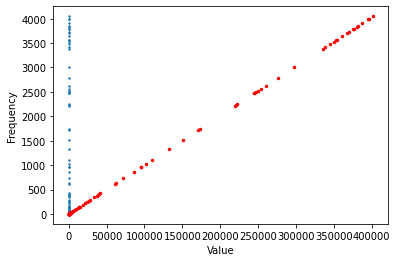

In [71]:
# Test workflow
# Use a simple validation set for cross-validation
#ann_model.test(test_set_in, test_set_out)
ann_model.plot_test(test_set_in, test_set_out)